In [195]:
import os
scripts_path = os.path.abspath('../scripts')
import importlib.util
spec = importlib.util.spec_from_file_location("helpers", os.path.join(scripts_path, "helpers.py"))
helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helpers)

spec = importlib.util.spec_from_file_location("nn_models", os.path.join(scripts_path, "nn_models.py"))
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)

import torch
import pandas as pd
from tqdm import trange

from sklearn.model_selection import train_test_split
from joblib import dump, load

## Data Setup

In [196]:
X_train, X_test, y_train, y_test = helpers.go_for_it_data_split(nn=True)
X_train, X_verify, y_train, y_verify = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_verify = torch.tensor(X_verify)
y_verify = torch.tensor(y_verify)

n_train, p = X_train.shape
n_verify, p = X_verify.shape

#### Testing / Training

In [197]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [198]:
# Hyperparameters
lr = 0.001
wd = 0.01
max_epochs = 350

# Print results
log_interval = 20

model = models.ConversionNNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_verify, y_verify, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_verify))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_verify))

torch.save(model.state_dict(), '../models/nn/conversion.joblib')

Epochs:   0%|          | 0/350 [00:00<?, ?it/s]/Users/loganpfahler/Spring 2023/Machine Learning/ML-final-project/scripts/nn_models.py:88: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/350 [00:01<10:42,  1.84s/it]

cross entropy loss 0.7004968024963556 0.6955937105066636
accuracy 0.5090106656859139 0.5323529411764706


Epochs:   6%|▌         | 21/350 [00:36<09:32,  1.74s/it]

cross entropy loss 0.6909793740095094 0.6892023423138787
accuracy 0.5090106656859139 0.5323529411764706


Epochs:  12%|█▏        | 41/350 [01:11<09:11,  1.78s/it]

cross entropy loss 0.6861729621887207 0.6860511330997243
accuracy 0.5185730047811695 0.5470588235294118


Epochs:  17%|█▋        | 61/350 [01:47<08:30,  1.77s/it]

cross entropy loss 0.682294815085655 0.6831802816951976
accuracy 0.6134608311879367 0.6073529411764705


Epochs:  23%|██▎       | 81/350 [02:22<07:36,  1.70s/it]

cross entropy loss 0.6784739133923553 0.6800104477826286
accuracy 0.6244942993747702 0.6029411764705882


Epochs:  29%|██▉       | 101/350 [02:57<07:05,  1.71s/it]

cross entropy loss 0.6745535509530888 0.6765612433938419
accuracy 0.6230231702831923 0.6014705882352941


Epochs:  35%|███▍      | 121/350 [03:28<05:49,  1.53s/it]

cross entropy loss 0.6705775066863658 0.6729701322667739
accuracy 0.6255976461934535 0.5926470588235294


Epochs:  40%|████      | 141/350 [03:58<05:15,  1.51s/it]

cross entropy loss 0.6667063319405844 0.6694523979635799
accuracy 0.6244942993747702 0.5926470588235294


Epochs:  46%|████▌     | 161/350 [04:29<04:55,  1.56s/it]

cross entropy loss 0.6630763730337453 0.666198865105124
accuracy 0.6230231702831923 0.5926470588235294


Epochs:  52%|█████▏    | 181/350 [05:00<04:45,  1.69s/it]

cross entropy loss 0.6597258448600769 0.6632099376005285
accuracy 0.6230231702831923 0.5955882352941176


Epochs:  57%|█████▋    | 201/350 [05:31<03:47,  1.52s/it]

cross entropy loss 0.6567090735879055 0.6605548185460708
accuracy 0.6248620816476645 0.5970588235294118


Epochs:  63%|██████▎   | 221/350 [06:02<03:31,  1.64s/it]

cross entropy loss 0.6540881423063056 0.658293555764591
accuracy 0.6267009930121368 0.6014705882352941


Epochs:  69%|██████▉   | 241/350 [06:37<03:07,  1.72s/it]

cross entropy loss 0.6518959818884383 0.6564336440142463
accuracy 0.6244942993747702 0.6058823529411764


Epochs:  75%|███████▍  | 261/350 [07:12<02:36,  1.75s/it]

cross entropy loss 0.6501056787579559 0.6549633699304918
accuracy 0.6241265171018757 0.6073529411764705


Epochs:  80%|████████  | 281/350 [07:48<01:59,  1.73s/it]

cross entropy loss 0.6486737686534261 0.6538411757525275
accuracy 0.6241265171018757 0.6073529411764705


Epochs:  86%|████████▌ | 301/350 [08:21<01:20,  1.64s/it]

cross entropy loss 0.6475177365680074 0.653004410687615
accuracy 0.625229863920559 0.6073529411764705


Epochs:  92%|█████████▏| 321/350 [08:53<00:47,  1.63s/it]

cross entropy loss 0.6465897740319718 0.6523921742158778
accuracy 0.625965428466348 0.6088235294117647


Epochs:  97%|█████████▋| 341/350 [09:26<00:14,  1.62s/it]

cross entropy loss 0.64583635884662 0.651947021484375
accuracy 0.6263332107392424 0.6073529411764705


Epochs: 100%|██████████| 350/350 [09:41<00:00,  1.66s/it]


#### Results

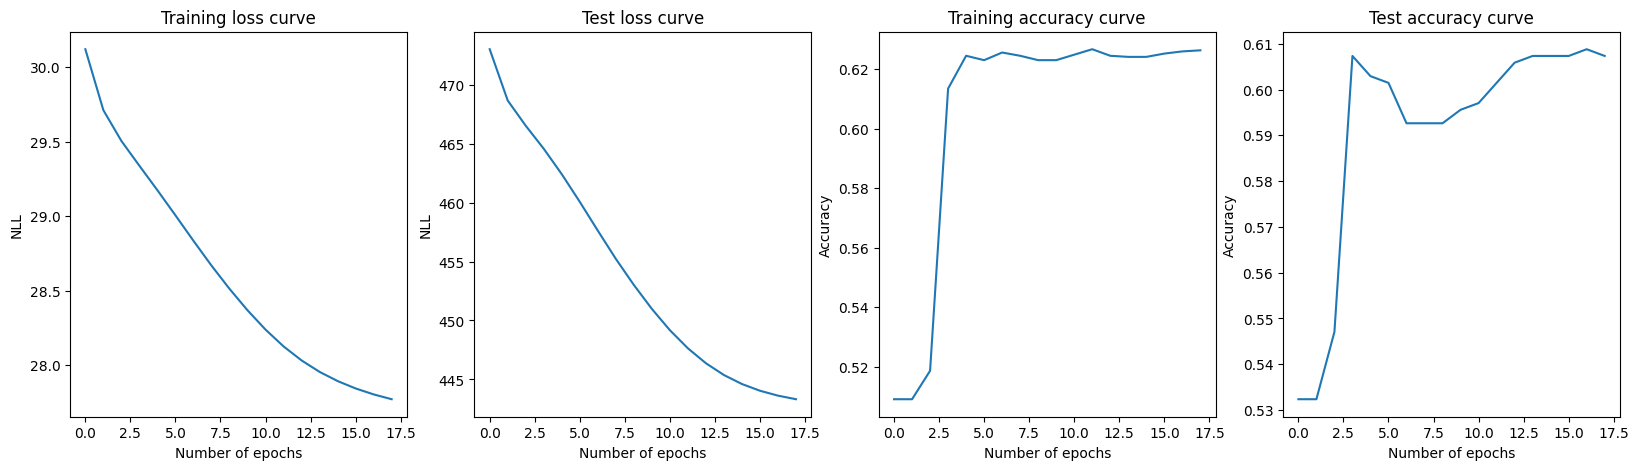

In [199]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_verify), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()

In [200]:
def predict(distance, yard_line, seconds_remaining, score_differential):
    scaler = load('../models/scaler.joblib')
    data = scaler.transform([[yard_line, seconds_remaining, distance, score_differential]])[0]
    data_desc = data_as_string(data)
    return predict_from_model(data), data_desc
    

def predict_from_model(data):
    input_var = torch.tensor(data).float()
    ans = model(input_var)
    probs = torch.nn.functional.softmax(ans, dim=0)
    return float(probs[0])

def data_as_string(data):
    scaler = load('../models/scaler.joblib')
    scaled_data = scaler.inverse_transform([data])[0]
    score_dif = int(scaled_data[3])
    seconds_remaining = int(scaled_data[1])
    yards_to_go = int(scaled_data[2])
    yard_line = int(scaled_data[0])
    ans = f"4th down and {yards_to_go} on "
    if (yard_line < 50):
        ans += f"the {yard_line}"
    else:
        ans += f"their own {100 - yard_line}"
    ans += f" yard line, {seconds_remaining} seconds remaining, "
    if (score_dif < 0):
        ans += f"down by {-1 * score_dif}"
    elif (score_dif > 0):
        ans += f"up by {score_dif}"
    else:
        ans += "tie game."
    return ans

predict(1, 99, 300, 36)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/loganpfahler/Spring 2023/Machine Learning/ML-final-project/scripts/nn_models.py:88: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)


(0.6511252522468567,
 '4th down and 1 on their own 1 yard line, 300 seconds remaining, up by 36')